# 多重共線性と回帰係数の信頼度の話。あとリッジ回帰。

$$
\def\paren#1{\left(#1\right)}
\def\brac#1{\left[#1\right]}
\def\P#1{\Pr\paren{#1}}
\def\E#1{\mathbb{E}\brac{#1}}
\def\var#1{\mathrm{Var}\brac{#1}}
\def\hvar#1{\widehat{\mathrm{Var}}\brac{#1}}
\def\quad#1{\paren{#1}^2}
\def\inv#1{\paren{#1}^{-1}}
\def\Xij{X_{i, j}}
\def\vX{\mathbf{X}}
\def\vXj{\mathbf{X}_j}
\def\vXmj{\mathbf{X}_{\setminus j}}
\def\vY{\mathbf{Y}}
\def\vU{\mathbf{U}}
\def\hvU{\hat{\vU}}
\def\vVj{\mathbf{V}_j}
\def\hvVj{\hat{\vV}_j}
\def\vM{\mathbf{M}}
\def\vMj{\mathbf{M}_j}
\def\vMmj{\mathbf{M}_{\setminus j}}
\def\vP{\mathbf{P}}
\def\vW{\mathbf{W}}
\def\vI{\mathbf{I}}
\def\hbeta{\hat{\beta}}
\def\betamj{\beta_{\setminus j}}
\def\hbetamj{\hbeta_{\setminus j}}
\def\hgamma{\hat{\gamma}}
\def\hXij{\hat{X}_{i, j}}
\def\hVij{\hat{V}_{i, j}}
\def\bXj{\bar{X}_{j}}
$$

In [1]:
from __future__ import annotations
from typing import Any, Callable
from dataclasses import dataclass, asdict
from copy import deepcopy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from simulator import Simulator

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

## 線形回帰モデル
線形回帰モデル

$$
\begin{align}
    Y_i = X_i'\beta + U_i
\end{align}
$$

を考えます。ここで、$Y_i$は目的変数、$X_i = (X_{i, 1}, \dots, X_{i, J})'$は説明変数、$U_i$は誤差項を表します。
$i = 1, \dots, N$はサンプルを表す添字で、$\{X_i, Y_i\}_{i=1}^N$はランダムサンプリングされているとします。
$\beta = (\beta_1, \dots, \beta_J)'$は回帰係数です。

以下、表記を単純にするため行列を利用します。
$$
\begin{align}
    \vY = \vX\beta + \vU
\end{align}
$$

それぞれの行列は以下で構成されています。

$$
\begin{align}
    \vY = \underbrace{\begin{pmatrix}
        Y_1 \\ 
        \vdots \\ 
        Y_N 
    \end{pmatrix}}_{N \times 1},\;\;
    \vX = \begin{pmatrix}
        X_{1}'\\ 
        \vdots \\ 
        X_{N}'
    \end{pmatrix}
    = \underbrace{\begin{pmatrix}
        X_{1, 1} & \cdots & X_{1, J}\\ 
        \vdots & \ddots & \vdots \\ 
        X_{N, 1} &  \cdots & X_{N, J}
    \end{pmatrix}}_{N \times J},\;\;
    \vU = \underbrace{\begin{pmatrix}
        U_1 \\ 
        \vdots \\ 
        U_N 
    \end{pmatrix}}_{N \times 1}
\end{align}
$$

標準的な仮定として$\E{\vU \mid \vX} = 0$をおきます。
また、話を簡単にするために、分散均一性$\Var{\vU \mid \vX} = \sigma^2\vI_N$も仮定しておきます。

## OLS推定量

このとき、最小二乗法（Ordinary Least Squares）を用いた推定量は以下で与えられます。

$$
\begin{align}
    \hbeta &= \arg\min_{\beta} \paren{\vY - \vX\beta}'\paren{\vY - \vX\beta}\\
    &=\inv{\vX'\vX}\vX'\vY
\end{align}
$$

これをOLS推定量と呼びます。
いま興味があるのは、このOLS推定量の信頼度と多重共線性の関係です。
この記事では、多重共線性があるとOLSを推定量の信頼性が低くなっていくことを示します。

まず第一に、もし完全な多重共線性が発生していると、$\vX'\vX$がランク落ちして逆行列が取れません。
よって、完全な多重共線性がある場合はそもそも回帰係数が推定できないということになります。
これは多重共線性が最も問題になるケースです。
この場合、完全な多重共線性を回避すべく余計な説明変数を削除するなどの調整が必要になります。

以下では、完全な多重共線性は起きていないとして話を進めます。
つまり、$\vX'\vX$がフルランクであることを仮定します。
$\vY = \vX\beta + \vU$だったことを思い出すと、OLS推定量$\hbeta$は以下のように変形できます。

$$
\begin{align}
    \hbeta &= \inv{\vX'\vX}\vX'\paren{\vX\beta + \vU}\\
    &= \inv{\vX'\vX}\vX'\vX\beta + \inv{\vX'\vX}\vX'\vU\\
    &= \beta + \inv{\vX'\vX}\vX'\vU
\end{align}
$$

この変形からOLSを推定量に関する重要な指標である期待値と分散を知ることができます。
まずは期待値をとると、$\E{\vU \mid \vX} = 0$の仮定のおかげで
$$
\begin{align}
    \E{\hbeta \mid \vX} &= \beta + \inv{\vX'\vX}\vX'\E{\vU \mid \vX}\\
    &= \beta
\end{align}
$$
となり、OLS推定量の期待値は真の回帰係数$\beta$と一致することがわかります。
この性質は不偏性と呼ばれています。

また、OLS推定量の分散は
$$
\begin{align}
\var{\hbeta_j \mid \vX} 
&= \var{\inv{\vX'\vX}\vX'\vU \mid \vX}\\
&= \inv{\vX'\vX}\vX'\var{\vU \mid \vX}\vX\inv{\vX'\vX}\\
&= \inv{\vX'\vX}\vX'\sigma^2\vI_N\vX\inv{\vX'\vX}\\
&= \inv{\vX'\vX}\sigma^2
\end{align}
$$
となることがわかります。
ここで、分散均一性の仮定$\Var{\vU \mid \vX} = \sigma^2\vI_N$を使っていることに注意して下さい。

推定量の分散はその推定量がどのくらい安定しているのかを表す指標と言えます。
実際、推定量の分散の平方根をとったものは標準誤差と呼ばれていて、信頼区間の計算や統計的仮説検定に利用します。

ところで、いま知りたいことは、多重共線性と推定量の信頼度（＝分散）の関係でした。
残念ながら、$\var{\hbeta_j \mid \vX} = \inv{\vX'\vX}\sigma^2$という式からは多重共線性がある場合に分散がどうなるのかいまいち想像ができません。
そこで、$\var{\hbeta_j \mid \vX}$を別の形で表現することにします。

## Annihilator Matrix

後の行列操作を楽にするために、Annihilator Matrix $\vM$を導入します（これがなぜAnnihilatorと呼ばれているのかはよくわかりません）。

$$
\begin{align}
    \vM = \vI_N - \vX\inv{\vX'\vX}\vX'
\end{align}
$$

行列$\vM$は以下の性質を持ちます。
かなり便利なのでこの記事を読む間だけ覚えておいてください。

- $\vM' = \vM$：転地しても同じ行列
- $\vM\vM = \vM$：かけても同じ行列
- $\vM\vX = 0$：説明変数にかけるとゼロ
- $\vM\vY = \vY - \vX\hbeta = \hvU$：目的変数にかけると残差になる

実際、簡単な行列計算から上記の性質が成り立っていることが見て取れます。
$$
\begin{align}
    \vM' 
    &= \paren{ \vI_N - \vX\inv{\vX'\vX}\vX'}' \\
    &= \vI_N - \vX\inv{\vX'\vX}\vX' \\
    &= \vM\\
    \vM\vM 
    &= \paren{ \vI_N - \vX\inv{\vX'\vX}\vX'}\paren{\vI_N - \vX\inv{\vX'\vX}\vX'} \\
    &= \vI_N - \vX\inv{\vX'\vX}\vX' - \vX\inv{\vX'\vX}\vX' + \vX\inv{\vX'\vX}\vX' \\
    &= \vM\\
    \vM\vX &= X - \vX\inv{\vX'\vX}\vX'\vX \\
    &= 0\\
    \vM\vY &= Y - \vX\inv{\vX'\vX}\vX'\vY \\
    &= \vY - X\hbeta\\
    &= \hvU
\end{align}
$$

$\vM\vY = \vY - \vX\hbeta = \hvU$という性質から、$\vM$は線形回帰モデルの残差を作る行列として知られています。

## OLS推定量の別表現

それでは、残差を作る行列$\vM$を用いてOLS推定量を別の形で表現できることを示します。
まず、線形回帰モデルを説明変数$\vXj$に関する部分と、それ以外の部分$\vXmj$に分解します。

$$
\begin{align}
    \vY = \vXj\beta_j + \vXmj\betamj + \vU
\end{align}
$$

ここで、それぞれの行列は以下を表しています。

$$
\begin{align}
    \vXj &= (X_{1, j}, \dots, X_{N, j})'\\
    \vXmj &= (\vX_1, \dots, \vX_{j-1}, \vX_{j+1}, \dots \vX_{J})\\
    \betamj &= (\beta_1, \dots, \beta_{j-1}, \beta_{j+1}, \dots \beta_{J})'
\end{align}
$$

いま、説明変数$\vXj$に対するOLS推定量$\hbeta_j$を知りたいとします。
通常の最小二乗法はすべての$\beta$を同時に動かして二乗誤差を最小にしますが、
まず$\betamj$を動かして二乗誤差を最小にし、残った部分に対して改めて$\beta_j$を動かして二乗誤差を最小にする$\hbeta_j$を求める、という二段階のステップを踏んでも同じ結果になります。
この操作を数式で表現すると以下になります。

$$
\begin{align}
    \hbeta_j &= \arg\min_{\beta_j}\brac{\min_{\betamj}\paren{\vY - \vXj\beta_j - \vXmj\betamj}'\paren{\vY - \vXj\beta_j - \vXmj\betamj}}
\end{align}
$$

内側の最小化問題をよく見ると、これは$\vY - \vXj\beta_j$に対して$\vXmj\betamj$で回帰していると解釈できるので、そのOLS推定量は以下で求めることができます。

$$
\begin{align}
    \hbetamj &= \inv{\vXmj'\vXmj}\vXmj'\paren{\vY - \vXj\beta_j}
\end{align}
$$

これを内側の最小化問題に戻すことを考えると

$$
\begin{align}
    \vY - \vXj\beta_j - \vXmj\hbetamj 
    &= \vY - \vXj\beta_j - \vXmj\inv{\vXmj'\vXmj}\vXmj'\paren{\vY - \vXj\beta_j}\\
    &= \paren{\vI_N  - \vXmj\inv{\vXmj'\vXmj}\vXmj'}\paren{\vY - \vXj\beta_j}\\
    & = \vMmj\paren{\vY - \vXj\beta_j}\\
    &= \vMmj\vY - \vMmj\vXj\beta_j
\end{align}
$$


なので、元の最小化問題は

$$
\begin{align}
    \hbeta_j &= \arg\min_{\beta_j}\paren{\vMmj\vY - \vMmj\vXj\beta_j}\paren{\vMmj\vY - \vMmj\vXj\beta_j}
\end{align}
$$

となることが分かります。

ここから、OLS推定量は

$$
\begin{align}
    \hbeta_j &= \inv{\vXj'\vMmj'\vMmj\vXj}\vXj'\vMmj'\vMmj\vY\\
    &= \inv{\vXj'\vMmj\vXj}\vXj'\vMmj\vY\\
\end{align}
$$

という形式でも表現できることがわかりました。

## 補助回帰

OLS推定量を別形式で表現できましたが、ここに出てくる$\vMmj\vXj$は何を計算しているのでしょうか？
残差を作る行列$\vMmj$の意味を考えると、$\vMmj\vXj$は説明変数$\vXj$を他の説明変数$\vXmj$で回帰したときの残差を表しています。
つまり、線形回帰モデル

$$
\begin{align}
    \vXj = \vXmj\gamma + \vVj
\end{align}
$$

に対する残差

$$
\begin{align}
    \vMmj\vXj = \vXj -  \vXmj\inv{\vXmj'\vXmj}\vXmj'\vXj = \vXj - \vXmj\hgamma = \hvVj
\end{align}
$$

を表現しています。
残差が$\hvVj$小さければ、説明変数$\vXj$は他の説明変数$\vXmj$でほぼ表現できてしまうということになります。
この場合、説明変数$\vXj$は追加的に与える情報量の少ない説明変数ということになります。
一方で、残差が$\hvVj$が大きい場合は、説明変数$\vXj$は他の説明変数では与えることのできない情報をモデルに与えていると言えます。

これを多重共線性の文脈でいうと、残差$\hvVj$が小さいことは（説明変数$\vXj$に対する）多重共線性が強いことに対応し、残差$\hvVj$が大きいことは多重共線性が弱いことに対応します。
実際、完全な多重共線性がある状態として$\vXj = \vX_k$となるような別の特徴量が存在するケースを考えると、残差$\hvVj$もゼロになります。

## OLS推定量の分散を解釈する

それでは、改めてOLS推定量の分散について考えましょう。
$\vY = vXj\beta_j + \vXmj\betamj + \vU$であったことを思い出すと、OLS推定量は以下のように変形できます。
$$
\begin{align}
    \hbeta_j &= \inv{\vXj'\vMmj \vXj}\vXj'\vMmj\paren{\vXj\beta_j + \vXmj\betamj + \vU}\\
    &= \underbrace{\inv{\vXj'\vMmj \vXj}\vXj'\vMmj\vXj}_{=\vI_J}\beta_j 
    + \inv{\vXj'\vMmj \vXj}\vXj'\underbrace{\vMmj\vXmj}_{=0}\betamj 
    + \inv{\vXj'\vMmj \vXj}\vXj'\vMmj\vU\\
    &= \beta_j + \inv{\vXj'\vMmj \vXj}\vXj'\vMmj\vU\\
    &= \beta_j + \inv{\vXj'\vMmj\vMmj\vXj}\vXj'\vMmj\vMmj\vU\\
    &= \beta_j + \inv{\hvVj'\hvVj}\hvVj'\vU
\end{align}
$$

これの分散をとると

$$
\begin{align}
\var{\hbeta_j \mid \vX} 
&= \var{\inv{\hvVj'\hvVj}\hvVj'\vU \mid \vX}\\
&= \inv{\hvVj'\hvVj}\hvVj'\var{\vU \mid \vX}\hvVj\inv{\hvVj'\hvVj}\\
&= \inv{\hvVj'\hvVj}\hvVj'\sigma^2\vI_N\hvVj\inv{\hvVj'\hvVj}\\
&= \inv{\hvVj'\hvVj}\sigma^2
\end{align}
$$

となります。
さらに、$\hvVj'\hvVj = \sumi \hVij^2 = \sumi\quad{\Xij - \hXij}$であることを利用すると、

$$
\begin{align}
\var{\hbeta_j \mid \vX} 
&= \frac{\sigma^2}{\sumi\quad{\Xij - \hXij}}
\end{align}
$$

と表現できます。
説明変数$\vXj$の平均を$\bXj = \frac{1}{N}\sumi X_{i, j}$として、分母に$\sumi \quad{\Xij - \bXj}$をかけて割ると

$$
\begin{align}
\var{\hbeta_j \mid \vX} &= \frac{\sigma^2}{\sumi \quad{\Xij - \hXij} / \sumi \quad{\Xij - \bXj}} \times \frac{1}{N \times \frac{1}{N}\sumi \quad{\Xij - \bXj}}\\
&= \frac{\sigma^2}{N\paren{1 - R^2_j}\hvar{X_j}}
\end{align}
$$

を得ます。
ここで、$R^2_j$は説明変数$\vXj$をその他の説明変数$\vXmj$で回帰したときの決定係数で、$\vXmj$で$\vXj$をどのくらい説明できてしまうかを表しています。
また、$\hvar{X_j}$は説明変数$\vX_j$の標本分散を表しています。

さて、ここまで長い道のりでしたが、この表現から多重共線性がOLS推定量の分散（信頼度）にどう影響するかを解釈することができます。

1. 説明変数$\vX$では説明できない目的変数$\vY$の変動$\sigma^2$が大きければ大きいほど、分散が大きくなる
2. サンプルサイズ$N$が大きくなると、分散が小さくなる
3. 説明変数$\vX_j$の標本分散$\hvar{X_j}$が大きくなると、分散が小さくなる
4. 決定係数$R^2_j$が大きくなると、分散が大きくなる

1.はデータの限界みたいなところがあるので言っても仕方ないかなと思っています。

2.は当たり前といえば当たり前で、データが多いと推定量の信頼性が上がっていくのはよく言われていることですね。
ただ、$\var{\hbeta_j \mid \vX} = \inv{\vX'\vX}\sigma^2$という表現からは明示的には見えてこなかった部分ではあります。

3.は説明変数の取りうる値のレンジが大きいと回帰係数が小さくなることからくる性質なので、これもあんまり気にしなくていいと思います。
実際、説明変数をあらかじめ標準化すると分散が1になるので無視できます。
これも$\var{\hbeta_j \mid \vX} = \inv{\vX'\vX}\sigma^2$という表現からは明示的には見えてこなかった部分ではあります。

やはり重要なのは4.で、説明変数$\vXj$をその他の説明変数$\vXmj$で説明できてしまう割合が大きいと、OLS推定量$\hbeta_j$の信頼性が下がることが見て取れます。
つまり、多重共線性があるケースで推定量の信頼性が下がることがわかります。
ここで重要なことは、$\hbeta_j$の信頼性に影響するのはあくまで$\hbeta_j$に対する決定係数$R_j^2$であることです。
言い換えると、$\vXj$とは関係ない説明変数同士で強い相関があったとしても、それらの説明変数が$\vXj$に対して説明力を持たないのであれば、$\hbeta_j$の信頼性に特に影響は与えません。
ですので、多重共線性を考える際には、あくまでいま興味のあるターゲットの説明変数$\vXj$に対する多重共線性のみに注意すればよく、他の説明変数で多重共線性が起きていても（その説明変数の回帰係数に興味がないなら）無視しても良いと言えます。

これが特に重要になってくるのは因果関係を考えるケースで、多重共線性を気にしてコントロール変数をむやみにモデルから外すと欠落変数バイアスが発生してしまいます。
ターゲットの説明変数と無関係の多重共線性は気にせず、論理的に入れるべきコントロール変数は入れるべきだと思います。
ターゲットの説明変数に対して強い多重共線性が発生しているケースは問題といえば問題だとは思うのですが、そもそもコントロール変数でほとんどの部分が説明できてしまう変数をターゲットにするのはどうなんだという話にもなるかなと思っています。

まとめると、完全な多重共線性はそもそも計算ができないので問題ですが、そうでなければ多重共線性はあまり気にしなくていいケースがほとんどだと思っています。

# シミュレーションによる確認
## シミュレーションの設定

OLS推定量の分散の振る舞いを数式からも確認しましたが、ここではシミュレーションを用いて理解を深めることにします。
以下の設定でシミュレーションデータを生成します。

$$
\begin{align}
    Y &= X_0 + X_1 + X_2 + U\\
    (X_0, X_1, X_2) &\sim \mathcal{N}\paren{
    \begin{pmatrix}
    0 \\ 0 \\ 0
    \end{pmatrix},\;
    \begin{pmatrix}
    1 & \rho & 0\\
    \rho & 1 & 0\\
    0 & 0 & 1 
    \end{pmatrix}
    }\\
    U &\sim \mathcal{N}\paren{0, \sigma^2}
\end{align}
$$

ここで、説明変数$X_0$と$X_1$は相関していて、$X_2$は無相関であるような設定を考えています。
様々な設定でシミュレーションを行うことができるように、`Simulator`クラスを定義しておきます。
以下では、この`Simulator`クラスを用いてシミュレーションを行います。

In [3]:
@dataclass
class Simulator:
    n_simulations: int
    n_samples: int
    n_features: int
    rho: float
    sigma_u: float

    def generate_simulation_data(
        self,
        n_simulations: int,
        n_samples: int,
        n_features: int,
        rho: float,
        sigma_u: float,
    ) -> tuple(np.ndarray, np.ndarray):
        """シミュレーションデータの生成"""

        # シミュレーションの設定
        # X0とX1のみ相関がありうる設定にする
        mean = np.zeros(n_features)
        cov = np.eye(n_features)
        cov[0, 1] = cov[1, 0] = rho

        # 特徴量とノイズを生成
        X = np.random.multivariate_normal(mean, cov, size=(n_simulations, n_samples))
        u = np.random.normal(0, sigma_u, size=(n_simulations, n_samples))

        # 係数はすべて1なので、単に和をとる
        y = X.sum(axis=2) + u

        return (X, y)

    @staticmethod
    def estimate(
        X: np.ndarray,
        y: np.ndarray,
        l2_lambda: float,
        n_simulations: int,
        n_samples: int,
        n_features: int,
        **kwargs,
    ) -> np.ndarray:
        """回帰係数を推定する"""

        XT = np.transpose(X, axes=(0, 2, 1))
        Y = y.reshape((-1, n_samples, 1))

        I = np.row_stack([np.eye(n_features)] * n_simulations)
        I = I.reshape(n_simulations, n_features, n_features)

        hbeta = np.linalg.inv(XT @ X + l2_lambda * I) @ (XT @ Y)

        return hbeta.reshape(-1, n_features)

    @staticmethod
    def calc_mean_var(
        hbeta: np.ndarray,
        target_key: str,
        target_values: list,
        n_features: int,
        **kwargs,
    ) -> pd.DataFrame:
        """シミュレーションでの回帰係数の平均と分散を計算する"""

        df = pd.DataFrame({target_key: target_values})
        df[[f"平均{j}" for j in range(n_features)]] = hbeta.mean(axis=1)
        df[[f"分散{j}" for j in range(n_features)]] = hbeta.var(axis=1)

        return df

    def simulate(
        self, target_key: str, target_values: list, l2_lambda: float = 0
    ) -> pd.DataFrame:
        """シミュレーションを実行する"""

        hbeta = np.zeros((len(target_values), self.n_simulations, self.n_features))
        params = asdict(self)
        for i, target_value in enumerate(target_values):
            params.update({target_key: target_value})
            X, y = self.generate_simulation_data(**params)
            hbeta[i, :, :] = self.estimate(X, y, l2_lambda, **params)

        return self.calc_mean_var(hbeta, target_key, target_values, **params)

    def plot(self, df: pd.DataFrame, target_key: str, kind: str) -> None:
        """シミュレーション結果を可視化"""
        
        fig, ax = plt.subplots()

        for j in range(self.n_features):
            ax.plot(df[target_key], df[f"{kind}{j}"], label=f"beta{j}")
        ax.legend()
        ax.set(xlabel=target_key, ylabel=kind)
        fig.suptitle(f"{target_key}と回帰係数の{kind}の関係")
        
        fig.savefig(f"output/{target_key}と回帰係数の{kind}の関係")
        fig.show()
        

ベースのパラメータは以下のように設定します。

In [4]:
base_params = {
    "n_simulations": 2000,  # シミュレーションの回数
    "n_samples": 100,  # サンプルサイズ
    "n_features": 3,  # 特徴量の数（3で決め打ち）
    "rho": 0.9,  # X0とX1の相関の強さ
    "sigma_u": 5,  # ノイズの大きさ
}

## 相関の強さと推定量の分散

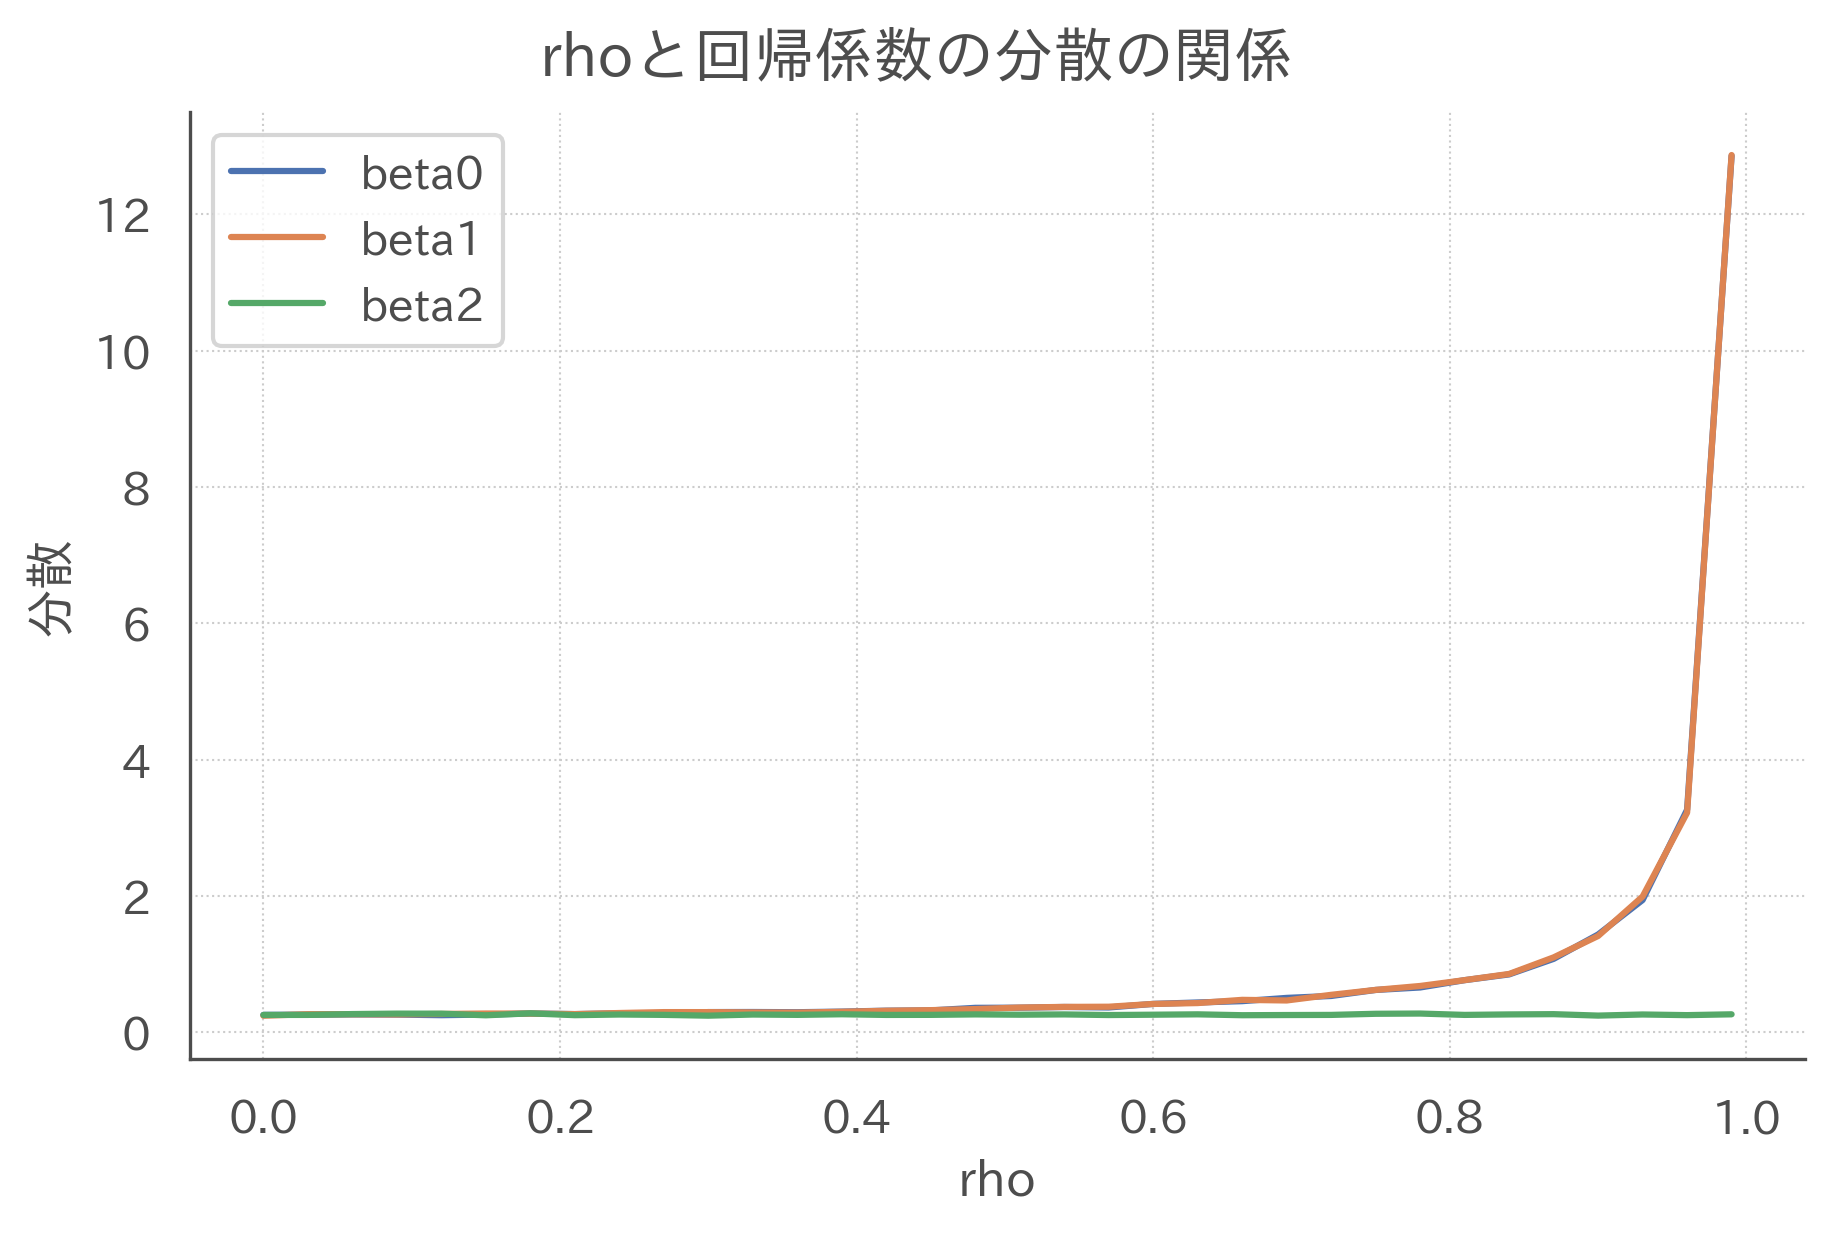

In [5]:
# 相関の強さを変えてシミュレーション
target_key = "rho"
target_values = np.arange(0, 1, 0.03).tolist()

s = Simulator(**base_params)
df = s.simulate(target_key, target_values)
s.plot(df, target_key, "分散")

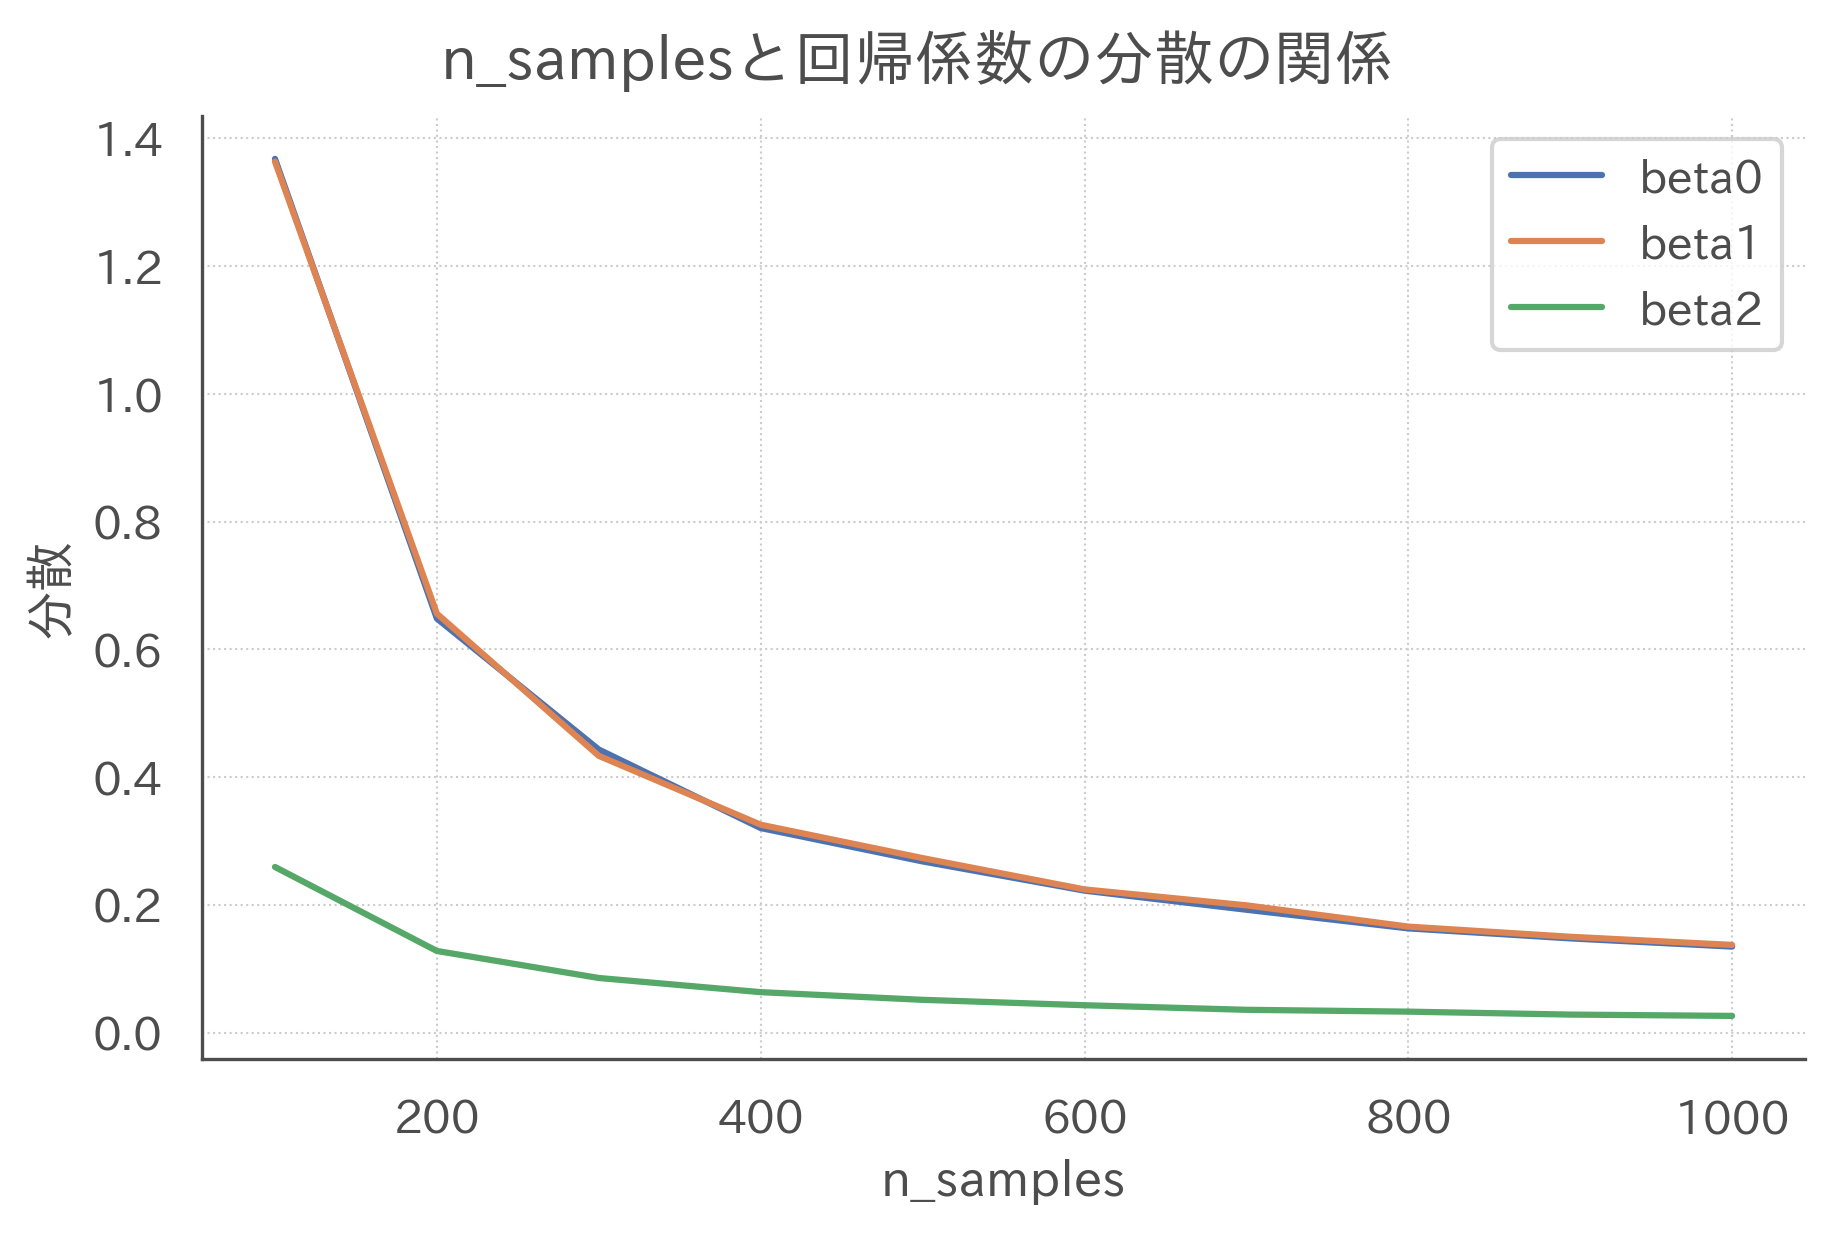

In [6]:
target_key = "n_samples"
target_values = np.arange(100, 1001, 100).tolist()

s = Simulator(**base_params)
df = s.simulate(target_key, target_values)
s.plot(df, target_key, "分散")

# リッジ回帰
## リッジ推定量の導入
ここまで、強い多重共線性が存在すると回帰係数の推定が安定せずOLS推定量$\hbeta$の信頼度が下がる（分散が大きくなる）ことを、数式とシミュレーションの両面から見てきました。
推定量の信頼度が低いと、回帰分析を用いた意思決定の信頼度が下がることに繋がります。

そこで、推定量の分散を抑える手法として、リッジ回帰（Redge Regression）という手法が知られています。
この手法では、最小二乗法を行う際の損失関数に、$\beta$が大きいほど強い罰則を与える罰則項を加えます。
この罰則によって、推定量は極端に大きな値を取らないような制限がかかり、推定が安定します。

$$
\begin{align}
    \hbeta(\lambda) &= \arg\min_{\beta} \paren{\vY - \vX\beta}'\paren{\vY - \vX\beta} + \lambda \beta'\beta\\
    &= \inv{\vX'\vX + \lambda \vI_J}\vX'\vY
\end{align}
$$

このような罰則を加えた推定量はリッジ推定量と呼ばれています。
ここで、$\lambda$は罰則の強さを表しています。
OLS推定量と比較して、$\lambda \vI_J$の項目が分母にある分、リッジ推定量のほうが（絶対値でみて）小さい値になります。
$\lambda$が大きいほど強い罰則がかかり、$\beta$が0方向に引っ張られます。
実際$\lambda$を無限大に飛ばすと推定量は0になります。
逆に、$\lambda = 0$のときは、リッジ推定量はOLS推定量と一致します。


## リッジ推定量の性質
それでは、リッジ推定量の性質を確認するため、その期待値と分散を計算します。

### 変換行列の準備
後の話を簡単にするため、OLS推定量をリッジ推定量に変換する行列$\vW$を定義しておきます。

$$
\begin{align}
    \vW\hbeta &=\hbeta(\lambda)
\end{align}
$$

行列$\vW$の中身を知りたいので、OLS推定量とリッジ推定量を代入します。

$$
\begin{align}
    \vW\hbeta &=\hbeta(\lambda) \\
    \vW \inv{\vX'\vX}\vX'\vY&= \inv{\vX'\vX + \lambda \vI_J}\vX'\vY
\end{align}
$$

両辺に$\inv{\vX'\vY}\paren{\vX'\vX}$を右からかけてあげると$\vW$の中身がわかります。

$$
\begin{align}
    \vW \inv{\vX'\vX}\vX'\vY\inv{\vX'\vY}\paren{\vX'\vX} &= \inv{\vX'\vX + \lambda \vI_J}\vX'\vY\inv{\vX'\vY}\paren{\vX'\vX}\\
    \vW&= \inv{\vX'\vX + \lambda \vI_J}\paren{\vX'\vX}
\end{align}
$$

### リッジ推定量の期待値

さて、この変換行列$\vW$を用いてリッジ推定量の期待値を計算します。

$$
\begin{align}
    \E{\hbeta(\lambda) \mid \vX} 
    &= \E{\vW\hbeta \mid \vX}\\
    &= \vW\E{\hbeta \mid \vX}\\
    &= \inv{\vX'\vX + \lambda \vI_J}\paren{\vX'\vX}\beta\\
    &\leqslant \beta
\end{align}
$$

OLS推定量とは異なり、リッジ推定量の期待値は真の回帰係数$\beta$と一致しません。
分母の$\lambda \vI_J$の分だけ0方向にバイアスがかかることがわかります。
よって、罰則の強さ$\lambda$を大きくすればするほどバイアスは大きくなります。

推定量にバイアスがかかるのはあまりうれしくない性質です。
ただ、バイアスの方向がゼロに向かうのは、実務的にはそんなに悪くない性質だと思っています。
というのも、ゼロ方向にバイアスがかかるというのは、説明変数が目的変数に与える効果を「過小評価」するという話なので、リッジ回帰で過小評価されていてもなお十分に効果があるなら、保守的に見てもそのくらいの効果がある可能性が高い、という判断が可能になるからです。

### リッジ推定量の分散

次に、リッジ推定量の分散について確認します。

$$
\begin{align}
    \var{\hbeta(\lambda) \mid \vX} 
    &= \var{\vW\hbeta \mid \vX}\\
    &= \vW\var{\hbeta \mid \vX}\vW'\\
    &= \inv{\vX'\vX + \lambda \vI_J}\paren{\vX'\vX}\inv{\vX'\vX}\sigma^2\paren{\vX'\vX}\inv{\vX'\vX + \lambda \vI_J}\\
    &= \inv{\vX'\vX + \lambda \vI_J}\paren{\vX'\vX}\inv{\vX'\vX + \lambda \vI_J}\sigma^2
\end{align}
$$

$\vW$は分母のほうが大きいので、リッジ推定量の分散はOLS推定量の分散より小さくなることがわかります。また、$\lambda$を大きくすれば分散が小さくなることも見て取れます。

まとめると、リッジ推定量は、バイアスがかかることを代償に推定量の信頼性を高める手法であると解釈できます。
このバイアスと信頼性の関係はBias-Variance tradeoffとして機械学習や統計学の分野で知られています。

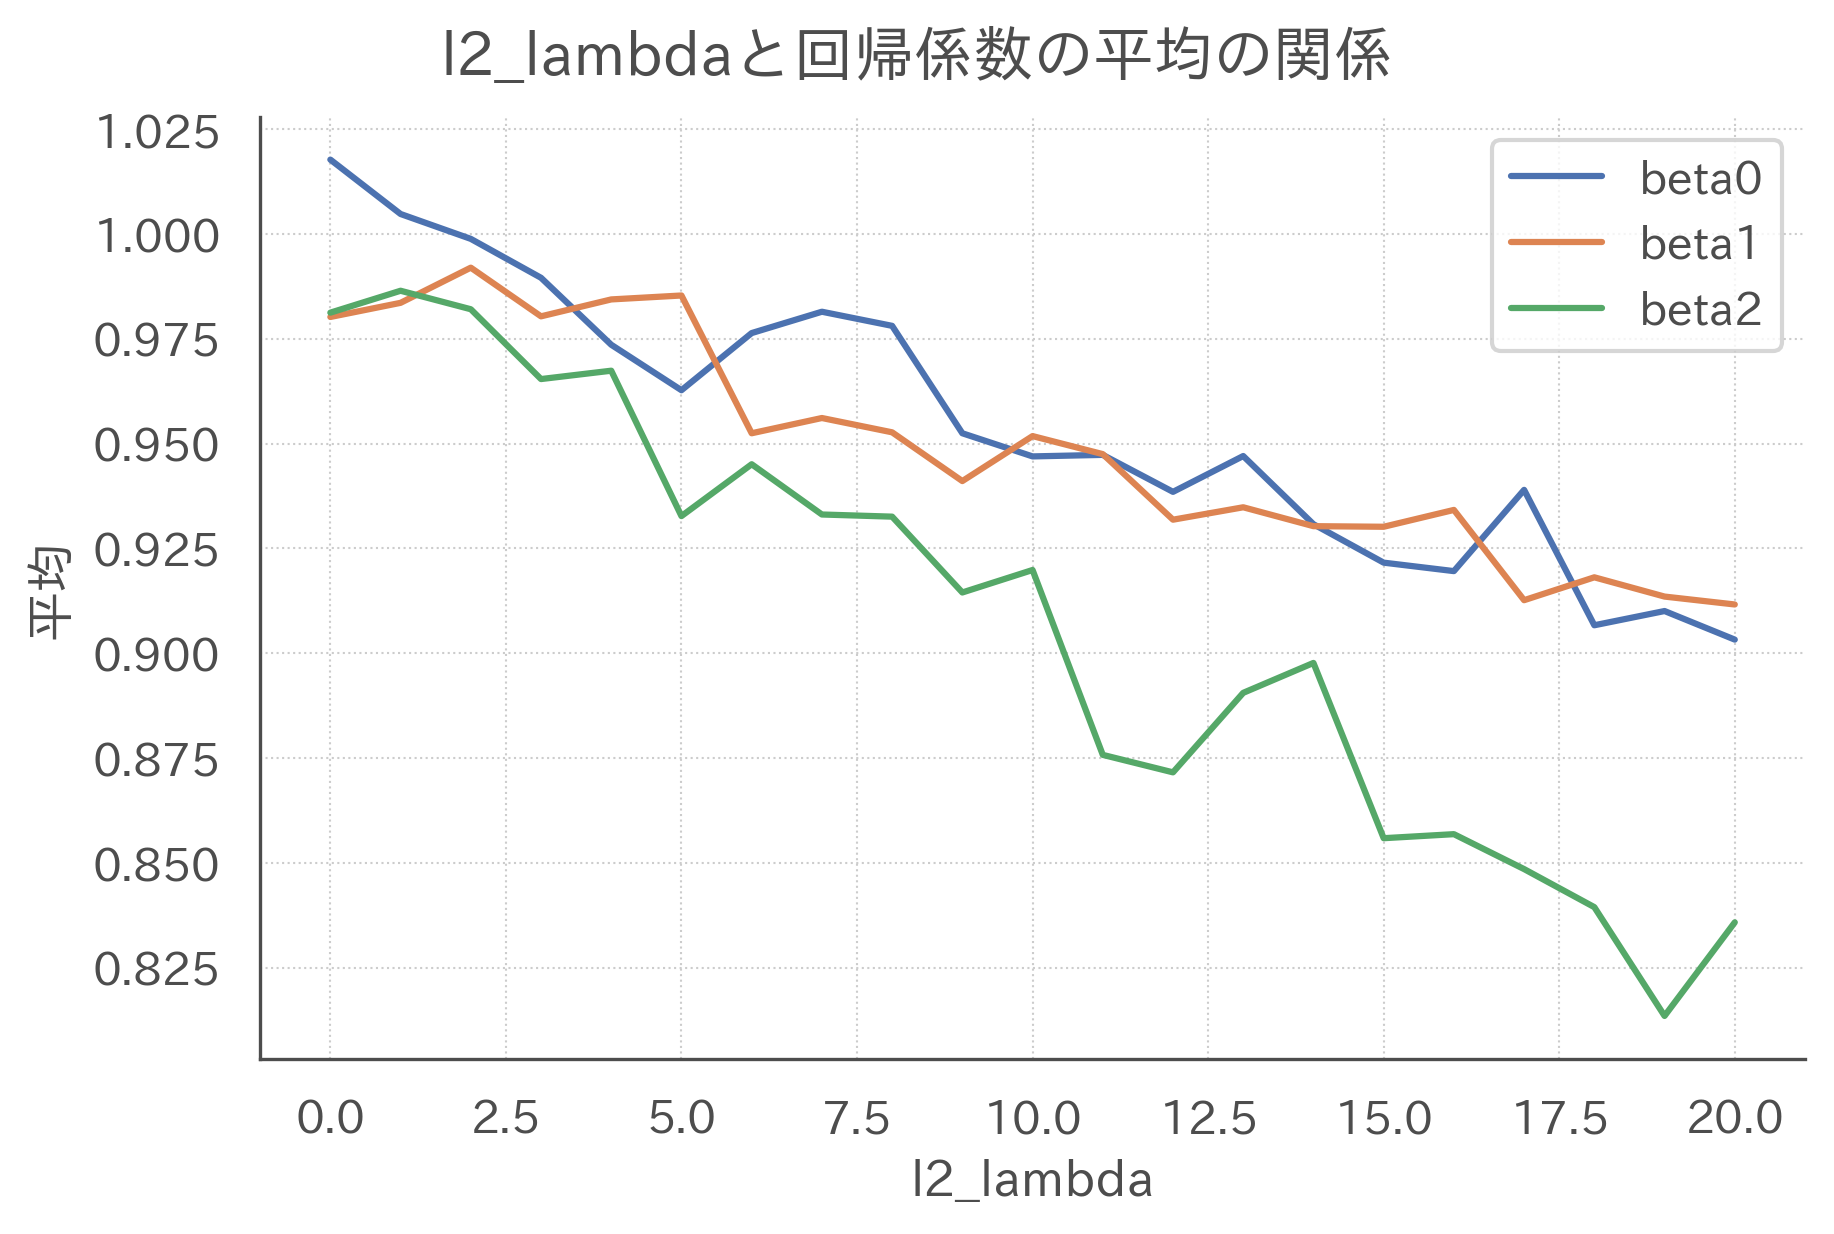

In [7]:
target_key = "rho"
target_values = [0.99]

s = Simulator(**base_params)
df = pd.concat([s.simulate(target_key, target_values, l2_lambda=l).assign(l2_lambda = l) for l in range(21)])
s.plot(df, "l2_lambda", "平均")

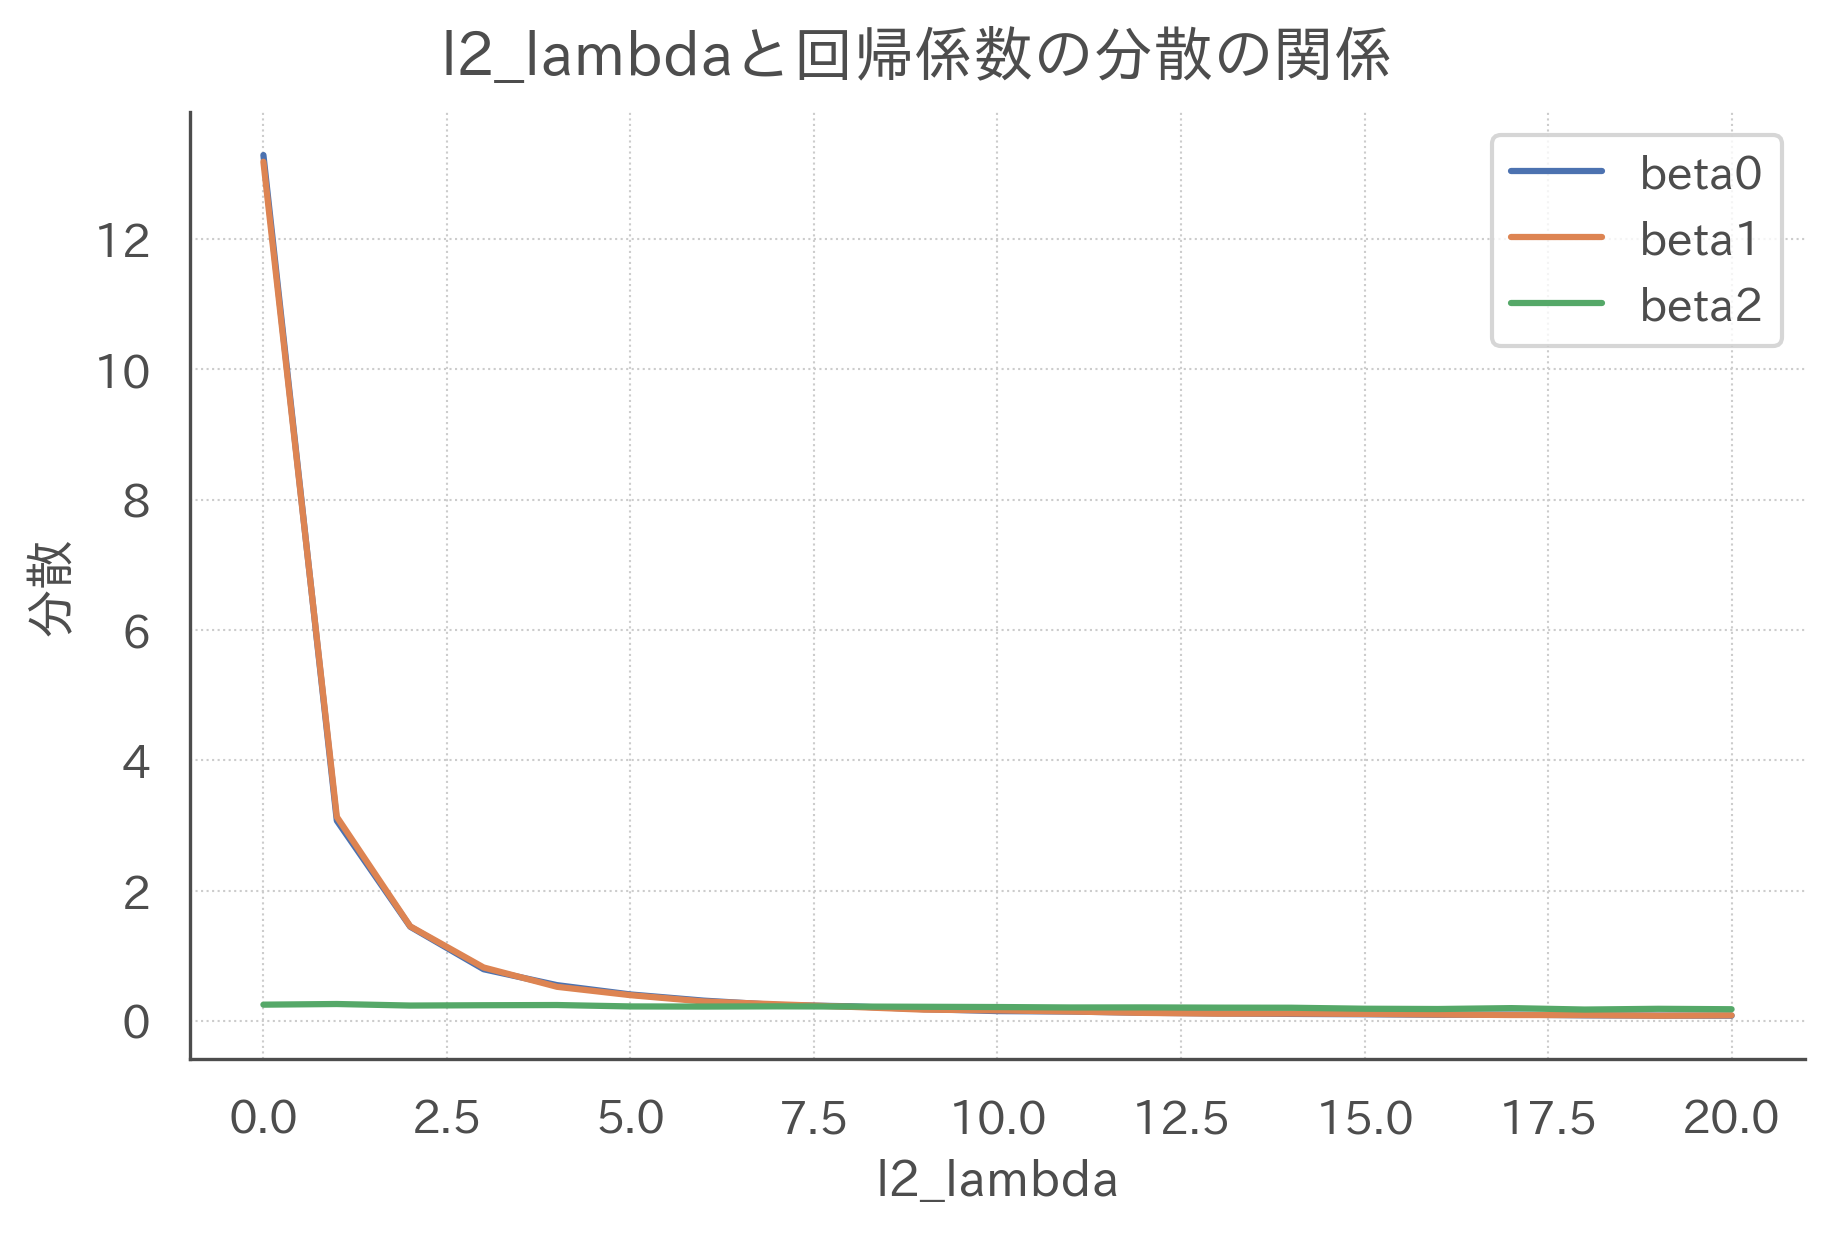

In [8]:
s.plot(df, "l2_lambda", "分散")

## 参考文献

- Hansen, Bruce E. "Econometrics." (2021). https://www.ssc.wisc.edu/~bhansen/econometrics/.
- van Wieringen, Wessel N. "Lecture notes on ridge regression." arXiv preprint arXiv:1509.09169 (2015).